In [1]:
# imports
import sys
sys.path.append( '..' )

from FIA.FIA import *
from ML.ML4com import *
from plot import *

In [71]:
run = "latent" # annot
run_dir = f"../../runs/ML/{run}"
report_dir = f"../../reports/ML"

source = "Com8_grown_together"
recon_loss = "mae_2"
project = f"{source}_{recon_loss}" if run.endswith("latent") else source

algorithms = ["Decision tree", "Extreme gradient boosting RF", "Gaussian Naive-Bayes", "K-neighbours classifier", "Linear Discriminant Analysis",
              "Logistic Regression", "Neural Network (MLP) SK-learn", "Random forest", "Support-vector classifier"]
matrices = ["metrics", "organism_metrics", "overall_metrics"]

dim_red_methods = {"Cosine": "cosine_2", "MAE": "mae_2", "MAE+Cosine": "mae_cosine_2", "Spectral Entropy": "se_2",
                   "MSE": "mse_2", "AE+Cosine": "ae+cosine_2", "Annotated":""}

In [72]:
metrics = pd.read_csv(os.path.join(run_dir, project, f"{algorithms[0]}_{matrices[0]}.tsv"), sep="\t", index_col=0)

In [138]:
def add_methodology(df, dim_red_method:str, classification_algorithm:str):
    df["Dimensionality reduction method"] = pd.Series([dim_red_method]*len(df))
    df["Classification algorithm"] = pd.Series([classification_algorithm]*len(df))
    return df

In [264]:
dfs = []
for dim_red_method, recon_loss in dim_red_methods.items():
    project = source if "nnot" in dim_red_method else f"{source}_{recon_loss}"
    dr_category = "annot" if "nnot" in dim_red_method else "latent"
    for algorithm in algorithms:
        path = os.path.join("../../runs/ML/", dr_category, project, f"{algorithm}_metrics.tsv")
        algorithm = algorithm.replace("SK-learn", "")
        algorithm = algorithm.replace("RF", "")
        dfs.append(add_methodology( pd.read_csv( path, sep="\t", index_col=0),
                                    dim_red_method=dim_red_method, classification_algorithm=algorithm))

In [265]:
pd.concat( dfs )

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat,Dimensionality reduction method,Classification algorithm
0,C. ramosum,1,0.739130,0.725000,[0. 0.73333333 0.86666667 1. ],[0. 0.25 0.75 1. ],[ inf 0.81927711 0.2 0. ],[[ 6 2]\n [ 4 11]],Cosine,Decision tree
1,C. ramosum,2,0.739130,0.658333,[0. 0.93333333 1. 1. ],[0. 0.625 0.875 1. ],[ inf 0.79761905 0.22222222 0. ],[[ 3 5]\n [ 1 14]],Cosine,Decision tree
2,C. ramosum,3,0.652174,0.654762,[0. 0.64285714 1. ],[0. 0.33333333 1. ],[inf 1. 0.],[[6 3]\n [5 9]],Cosine,Decision tree
3,C. ramosum,4,0.565217,0.523810,[0. 0.71428571 1. ],[0. 0.66666667 1. ],[inf 1. 0.],[[ 3 6]\n [ 4 10]],Cosine,Decision tree
4,C. ramosum,5,0.545455,0.535714,[0. 0.57142857 1. ],[0. 0.5 1. ],[inf 1. 0.],[[4 4]\n [6 8]],Cosine,Decision tree
...,...,...,...,...,...,...,...,...,...,...
43,R. intestinalis,2,0.833333,0.750000,[0. 0. 1. 1.],[0. 0.25 0.25 1. ],[ inf 1.12790127 0.45353769 -1.44725501],[[2 2]\n [0 8]],Annotated,Support-vector classifier
44,R. intestinalis,3,0.545455,0.428571,[0. 0. 0.57142857 0.57142857 1...,[0. 0.25 0.25 1. 1. ],[ inf 1.21731155 0.97623324 0.149036...,[[0 4]\n [1 6]],Annotated,Support-vector classifier
45,R. intestinalis,4,0.636364,0.500000,[0. 0.14285714 0.14285714 0.28571429 0...,[0. 0. 0.25 0.25 0.5 0.5 0.75 0.75 1. ...,[ inf 1.05490053 1.04443821 1.03802881 1...,[[0 4]\n [0 7]],Annotated,Support-vector classifier
46,R. intestinalis,5,0.636364,0.642857,[0. 0.14285714 0.28571429 0.28571429 0...,[0. 0. 0. 0.25 0.25 0.5 0.5 0.75 0.75 ...,[ inf 1.16244321 1.13499639 1.13079491 1...,[[0 4]\n [0 7]],Annotated,Support-vector classifier


In [448]:
c_dfs = pd.concat( dfs )
cfa = "Classification algorithm"
acc = "Accuracy"
drm = "Dimensionality reduction method"
org = "Organism"


In [523]:
def plot_dimred_results(df, x, y, hue, plottype, outpath):
    hue_order = list(c_dfs.groupby(hue)[y].mean().sort_values(ascending=False).index)
    sns.reset_defaults()
    if plottype=="cat":
        sns.set_style("darkgrid")
        ax = sns.catplot(
            data=df, x=x, y=y, hue=hue, hue_order=hue_order,
            kind="point", alpha=0.75, errorbar="se", aspect=1.7,
            palette=sns.blend_palette(["crimson", "gold", "violet", "turquoise", "mediumblue"], n_colors=len(hue_order), as_cmap=False)
            #palette=sns.diverging_palette(30, 240, l=65, sep=1, center="dark", as_cmap=False, n=9)
        )
        ax.tick_params(axis='x', labelrotation=0, labelsize=9)
        plt.ylim((0.45, 1.0))
    if plottype=="box":
        sns.set_style("darkgrid")
        sns.set(rc={"figure.figsize":(10, 6)})
        hue = x
        ax = sns.boxplot(
            data=pd.concat( dfs ), x=x, y=y, hue=hue,
            palette="vlag"
        )
        ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    plt.title(f"{y} of classifiers vs. {x}", fontdict= { 'fontsize': 11, 'fontweight':'bold'})
    plt.savefig(os.path.join(outpath, f"{plottype}_{x}_{y}_{hue}.png"), bbox_inches="tight")
    plt.show()

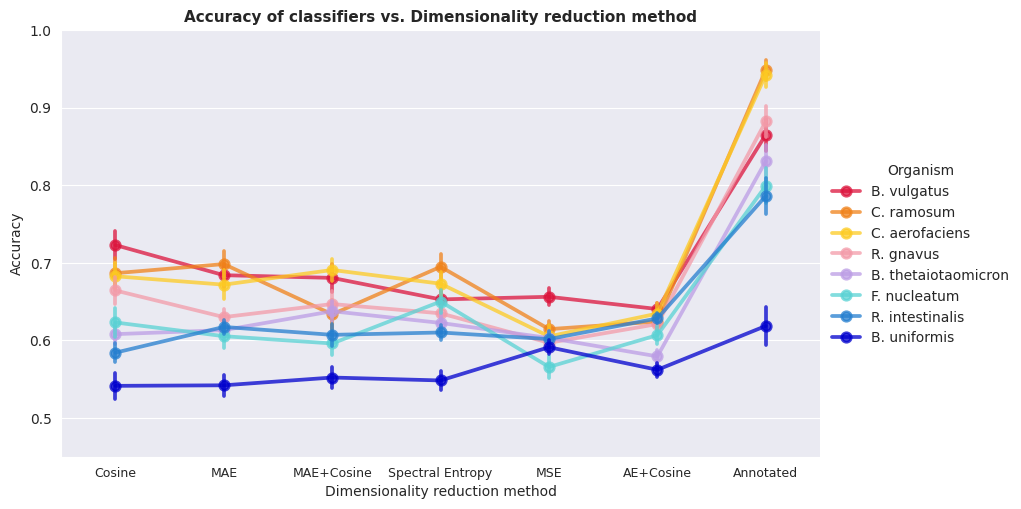

In [524]:
plot_dimred_results(df=c_dfs, x=drm, y=acc, hue=org, plottype="cat", outpath=report_dir)

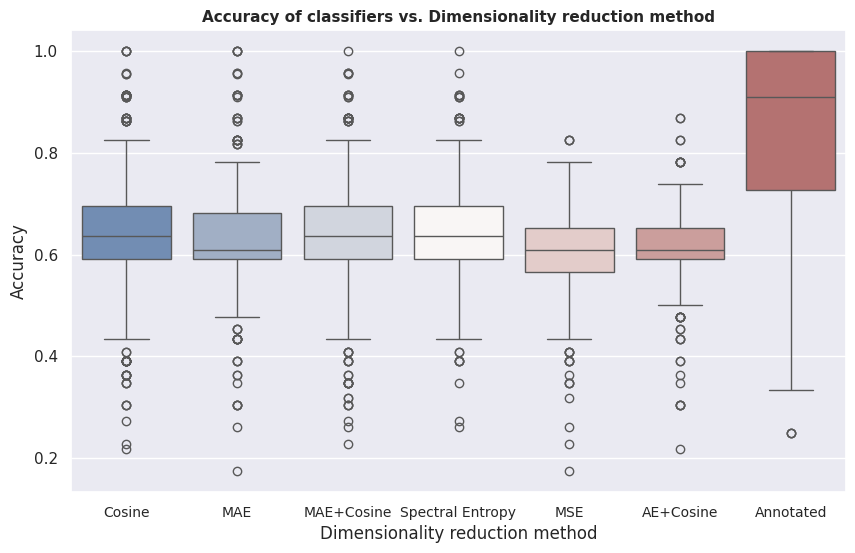

In [525]:
plot_dimred_results(c_dfs, drm, acc, cfa, "box", report_dir)